# CSS5228 Final Project

In this notebook, we will start training our model.

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from math import sqrt
import gc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from src.utils import highlight_top, save_fig

import warnings
warnings.filterwarnings("ignore")

# Import Data

In [8]:
df_train = pd.read_csv("../clean_data/train_preproc.csv", index_col=0)
df_test = pd.read_csv("../clean_data/test_preproc.csv", index_col=0)
df_submission = pd.read_csv("../raw_data/example-submission.csv")

In [9]:
df_train = df_train.drop(['property_type', 'subzone', 'planning_area'], axis=1)
df_test = df_test.drop(['property_type', 'subzone', 'planning_area'], axis=1)

In [10]:
X = df_train.drop("price", axis=1)
y = df_train["price"]
df_test = df_test.loc[:, X.columns]

# 1. Apply NN

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_valid)))
print(len(X_valid), len(y_valid))

Size of training set: 16076
Size of test: 4020
4020 4020


In [14]:
import tensorflow as tf
from tensorflow import keras 

np.random.seed(0)
tf.random.set_seed(0)

lstm_model = keras.models.Sequential([
    keras.layers.Dense(150, activation='relu', input_shape=[X_train.shape[1]],
                       kernel_initializer='random_normal',
                        bias_initializer='zeros'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.002)

lstm_model.compile(loss="mse", optimizer= optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

lstm_model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min',
                                               restore_best_weights=True)

history_mult_lstm2 = lstm_model.fit(X_train, y_train, epochs=10000, batch_size=25,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 150)               3450      
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                7550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best e

In [15]:
pred = lstm_model.predict(X_valid)

126/126 [==============================] - 1s 4ms/step


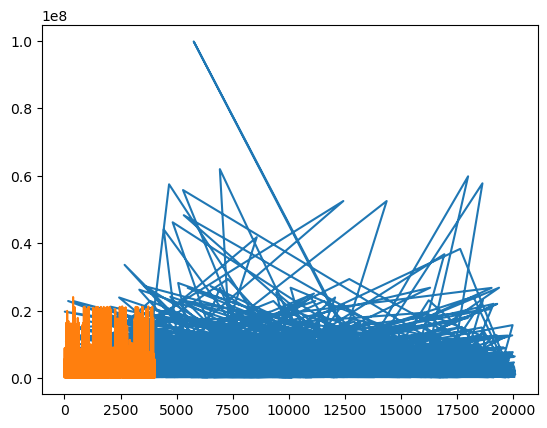

In [16]:
plt.plot(y_valid)
plt.plot(pred)

In [17]:
scaler = StandardScaler()
scaler.fit(np.log(df_train[["price"]] + 1))
pred=scaler.inverse_transform(pred)

In [18]:
pred

array([[2169762.  ],
       [4681031.5 ],
       [1739763.9 ],
       ...,
       [ 428330.  ],
       [5404196.  ],
       [ 288515.62]], dtype=float32)

In [19]:
y_preds = lstm_model.predict(df_test)

218/218 [==============================] - 1s 2ms/step


In [20]:
y_preds

array([[1714016.2],
       [1443041.8],
       [3012444.5],
       ...,
       [2678191.2],
       [ 942374.6],
       [2038097.5]], dtype=float32)

In [21]:
df_submission = pd.DataFrame({'Id': df_test.index,
                       'Predicted': y_preds.reshape(-1).round()})

In [22]:
df_submission = df_submission.loc[:,["Id", "Predicted"]]

In [23]:
df_submission.to_csv("submissions/train_NN_model.csv", index=0)